In [1]:
import pandas as pd

In [2]:
train_data = pd.read_csv("train.csv")

In [3]:
# Preprocessing train data
train_data['content'][:5]

0    0    In prokaryotic translation, how critical ...
1    1    Does anyone have any suggestions to preve...
2    2    Principles of Anatomy...\n2    I always u...
3    3    Various people in our lab will prepare a ...
4    4    Are there any cases in which the splicing...
Name: content, dtype: object

In [4]:
import boto3
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
bucket_name = 'sagemaker-us-east-2-904097069931'
tags = [{'Key': 'user:application','Value':'BlazingText'}]

region_name= boto3.Session().region_name
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [6]:
bt_model = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type='ml.c5.xlarge',
    train_volume_size=11,
    train_max_run=18000,
    base_job_name="blazingtext-blogs-sentences",
    output_path='s3://{}/models/blazingtext'.format(bucket_name),
    tags=tags
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [32]:
bt_model.set_hyperparameters(
    mode="batch_skipgram",
    epochs=10, 
    min_count=40,
    sampling_threshold=0.0001,
    learning_rate=0.05,
    window_size=5,
    vector_dim=100,
    negative_samples=5,
    batch_size=11,
    evaluation=True,
    subwords=False
)

In [33]:
input_data = f"s3://sagemaker-us-east-2-904097069931/train.csv"

bt_model.fit({'train': input_data}, logs=True)

2022-01-23 22:26:40 Starting - Starting the training job...
2022-01-23 22:27:03 Starting - Launching requested ML instancesProfilerReport-1642976800: InProgress
...
2022-01-23 22:27:30 Starting - Preparing the instances for training.........
2022-01-23 22:29:03 Downloading - Downloading input data
2022-01-23 22:29:03 Training - Downloading the training image...
2022-01-23 22:29:23 Training - Training image download completed. Training in progress.Arguments: train
[01/23/2022 22:29:14 WARNING 140271611176576] Loggers have already been setup.
[01/23/2022 22:29:14 WARNING 140271611176576] Loggers have already been setup.
[01/23/2022 22:29:14 INFO 140271611176576] nvidia-smi took: 0.025195598602294922 secs to identify 0 gpus
[01/23/2022 22:29:14 INFO 140271611176576] Running single machine CPU BlazingText training using batch_skipgram mode.
Number of CPU sockets found in instance is  1
[01/23/2022 22:29:14 INFO 140271611176576] Processing /opt/ml/input/data/train/train.csv . File size: 29.

In [34]:
bt_model.training_job_analytics.dataframe()

,timestamp,metric_name,value
0,0.0,train:mean_rho,0.40194


In [35]:
!aws s3 cp s3://sagemaker-us-east-2-904097069931/models/blazingtext/blazingtext-blogs-sentences-2022-01-23-21-11-48-941/output/model.tar.gz - | tar -xz

In [36]:
!pip install gensim

from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('vectors.txt', binary=False)

In [37]:
word_vectors.most_similar("family")

[('member', 0.5640313625335693),
 ('standard-visitor-visa', 0.4752252697944641),
 ('Me', 0.44151678681373596),
 ('loves', 0.43981480598449707),
 ('fiance', 0.4353905916213989),
 ('proof-provenance-of-funds', 0.43087127804756165),
 ('Euro...', 0.41397222876548767),
 ('passport.', 0.4105479121208191),
 ('eu-citizens', 0.4095986485481262),
 ('American,', 0.40801751613616943)]

In [38]:
word_vectors.most_similar("market")

[('sale', 0.48163384199142456),
 ('situation:', 0.39653292298316956),
 ('tray', 0.382204532623291),
 ('prepaid', 0.3768751323223114),
 ('completed', 0.3729654848575592),
 ('Mexican', 0.37169378995895386),
 ('ne...', 0.3645952045917511),
 ('DIY', 0.3598829209804535),
 ('plans', 0.35562077164649963),
 ('scallops', 0.3544520437717438)]

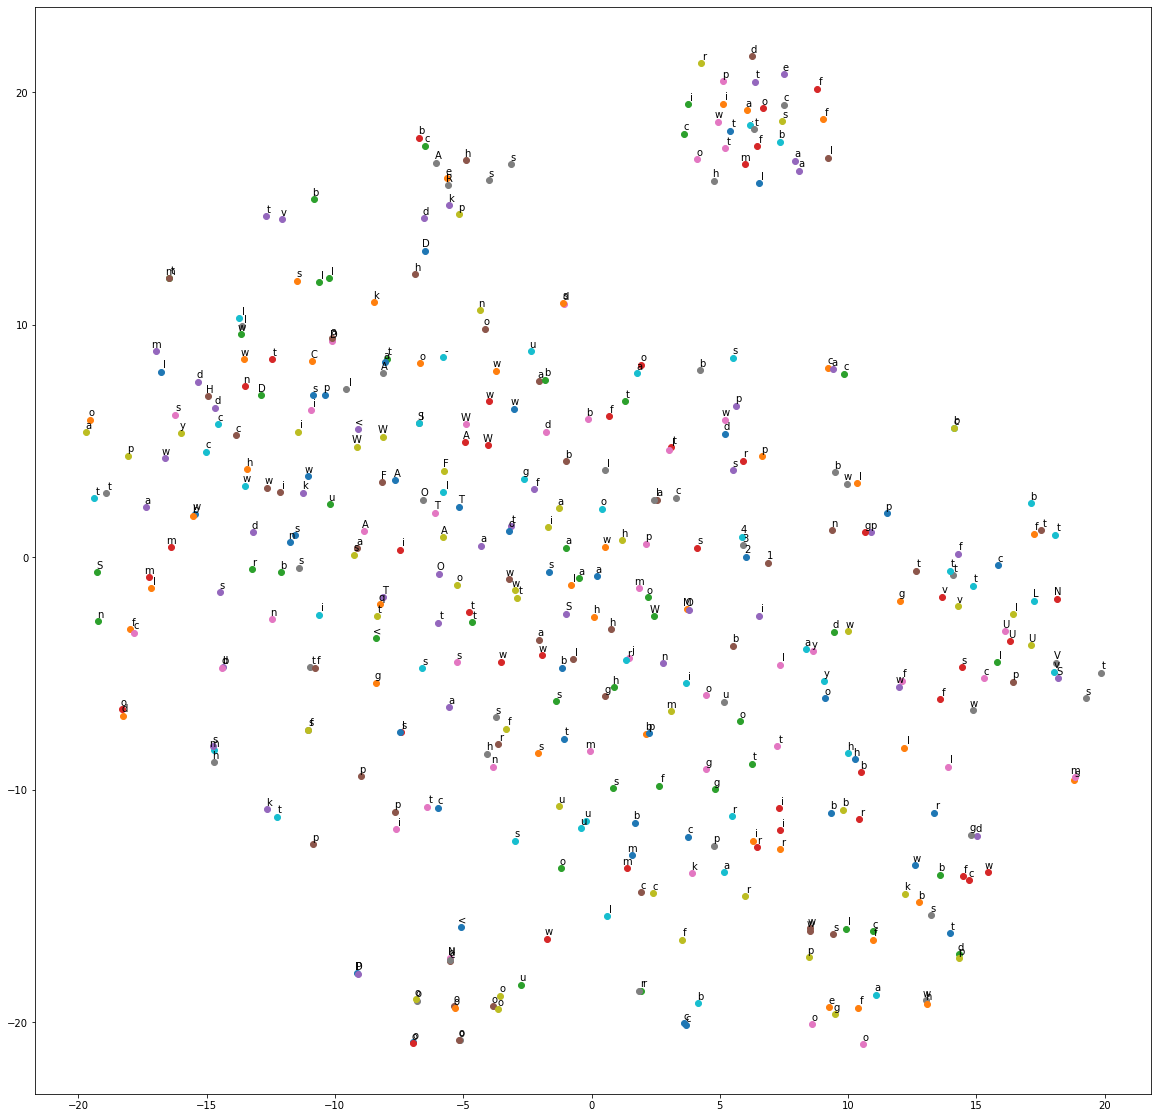